
# Asian Options Pricing & Hedging Tool

Course: FE 620: Pricing & Hedging | Stevens Institute of Technology

Advisor: Dan Pirjol

Group: Theo Dimitrasopoulos, Will Kraemer, Vaikunth Seshadri, Snehal Rajguru

Link: https://colab.research.google.com/drive/1Slsz4ExX6pUXAEqxK4veRJKeKFsD3n18

*Version: v10.0*

## **Runtime comments:**

* Click the execution button on the top left corner of each code cell to execute it. To run all cells in descending order, go to the menu bar at the top and click Runtime -> Run all (or use the **Ctrl-F9** or **⌘-F9** hotkey for Windows and MacOSX respectively);
* If the code is running slowly, go to Runtime -> Change runtime type, and change the Runtime Shape to High-RAM from the dropdown menu;
* The **"!pip install"** lines under the Python packages section (i.e. lines 3-5) only need to be executed the first time you run the notebook. If you receive the message **"Requirement already satisfied:"**, wrap them in treble quotes (add the quotes in lines 2 & 6)*.

## Python Packages

In [ ]:
# Install packages
'''
!pip install -q numpy
!pip install -q matplotlib
!pip install -q scipy
!pip install -q quandl
!pip install -q yfinance
'''

# Import Packages
import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
# import quandl
import timeit

## Inputs

### Underlying Asset Variables
Insert the desired values in the form fields (right) or directly to the code (left):

In [ ]:
#@title Pricer Parameters:

# Initial Underlying Price
S0 = 100#@param {type:"number"}

# Risk-free rate (also known as the drift coefficient)
r = 0.15#@param {type:"number"}

# Dividend Yield Rate
q = 0.0#@param {type:"number"}

# Maturity
T = 1.0#@param {type:"number"}

# Strike
K = 95#@param {type:"number"}

# Volatility (also known as the diffusion coefficient)
sigma = 0.3#@param {type:"number"}

# Number of Iterations for Monte Carlo Simulation
it = 10000#@param {type:"integer"}

# Time Steps
N = 100000#@param {type:"integer"}

## Plotting Parameters

### Aesthetic Parameters

In [0]:
#@title Element Sizes:

# Universal Plot width
width = 25 #@param {type:"integer"}

# Universal Plot height
height =  14#@param {type:"integer"}

# Universal xtick size
xtick_size = 8 #@param {type:"integer"}

# Universal ytick size
ytick_size =  8#@param {type:"integer"}

# Universal title font size
title_size = 18 #@param {type:"integer"}

# Universal xlabel font size
xlabel_size = 12 #@param {type:"integer"}

# Universal xlabel font size
ylabel_size = 12 #@param {type:"integer"}

# Universal legend font size
legend_size = 10 #@param {type:"integer"}

### Execute Parameters

In [0]:
#Set parameters
plt.rcParams['figure.figsize'] = (width,height)
params = {'text.color' : 'black',
          'xtick.color' : 'black',
          'ytick.color' : 'black',
          'xtick.labelsize' : xtick_size,
          'ytick.labelsize' : ytick_size,
          'legend.loc' : 'upper left',
         }
plt.rcParams.update(params)

## Definitions

### Brownian Path Generator

In [0]:
def bm_paths(N):
  seed = random.random()
  dt = T / N
  b_dt = np.random.normal(0., 1., N)*np.sqrt(dt)
  W = np.cumsum(b_dt)
  return W

### Geometric Brownian Path Generator

#### Conventional Implementation:

In [0]:
# NORMAL IMPLEMENTATION:
def gbm_paths(r,q,N,T,S0,sigma):
  t = np.linspace(0, T, N)
  b_t = np.random.normal(0., 1., int(N))*np.sqrt(T/N)
  W = np.cumsum(b_t)
  S = S0 * np.exp(sigma * W + (r - q - 0.5 * (sigma**2)) * t)
  S = np.insert(S, 0, S0)
  return S

#### Tensorflow Implementation:

In [0]:
def tf_graph_gbm_paths():
  S0 = tf.placeholder(tf.float32)
  K = tf.placeholder(tf.float32)
  dt = tf.placeholder(tf.float32)
  T = tf.placeholder(tf.float32)
  sigma = tf.placeholder(tf.float32)
  r = tf.placeholder(tf.float32)
  dw = tf.placeholder(tf.float32)
  S_i = S0 * tf.cumprod(tf.exp((r-sigma**2/2)*dt+sigma*tf.sqrt(dt)*dw), axis=1)
  return (S0, K, dt, T, sigma, r, dw, S_i)

In [0]:
def tf_gbm_paths():
  (S0,K, dt, T, sigma, r, dw, S_i) = tf_graph_gbm_paths()
  def paths(S_zero, strk, maturity, volatility, riskfrate, seed, iterations, timesteps):
    if seed != 0:
      np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(iterations, timesteps)
    with tf.Session() as sess:
      delta_t = maturity / timesteps
      res = sess.run(S_i, 
                     {
                         S0: S_zero,
                         K : strk,
                         r : riskfrate,
                         sigma: volatility,
                         dt : delta_t,
                         T: maturity,
                         dw : stdnorm_random_variates})
      return res
  return paths

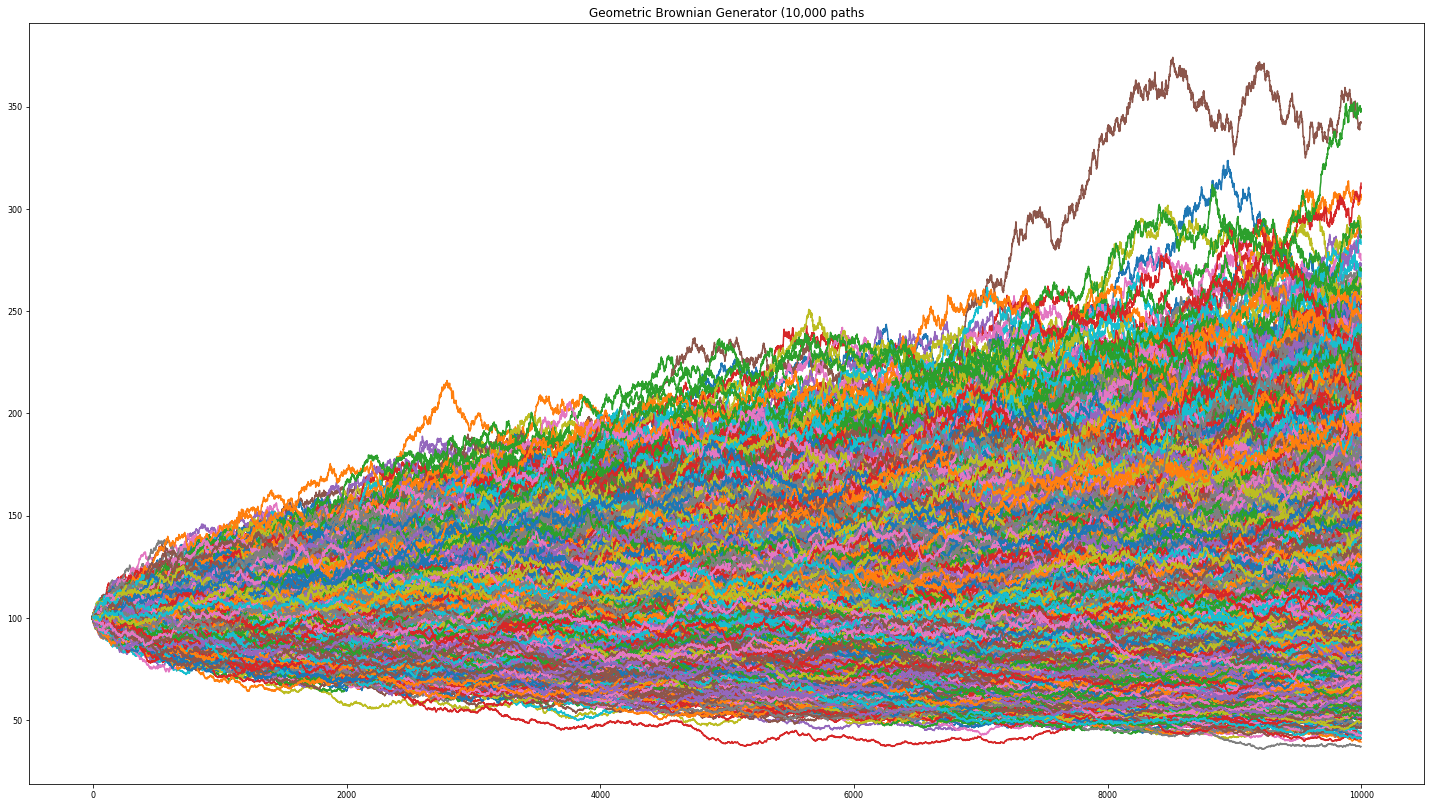

In [0]:
seed = np.random.randint(1,500)
data_generator = tf_gbm_paths()
S = data_generator(S0,K,T,sigma,r,seed,10000,10000)
plt.plot(np.transpose(S))
plt.title('Geometric Brownian Generator (10,000 paths')
plt.show()

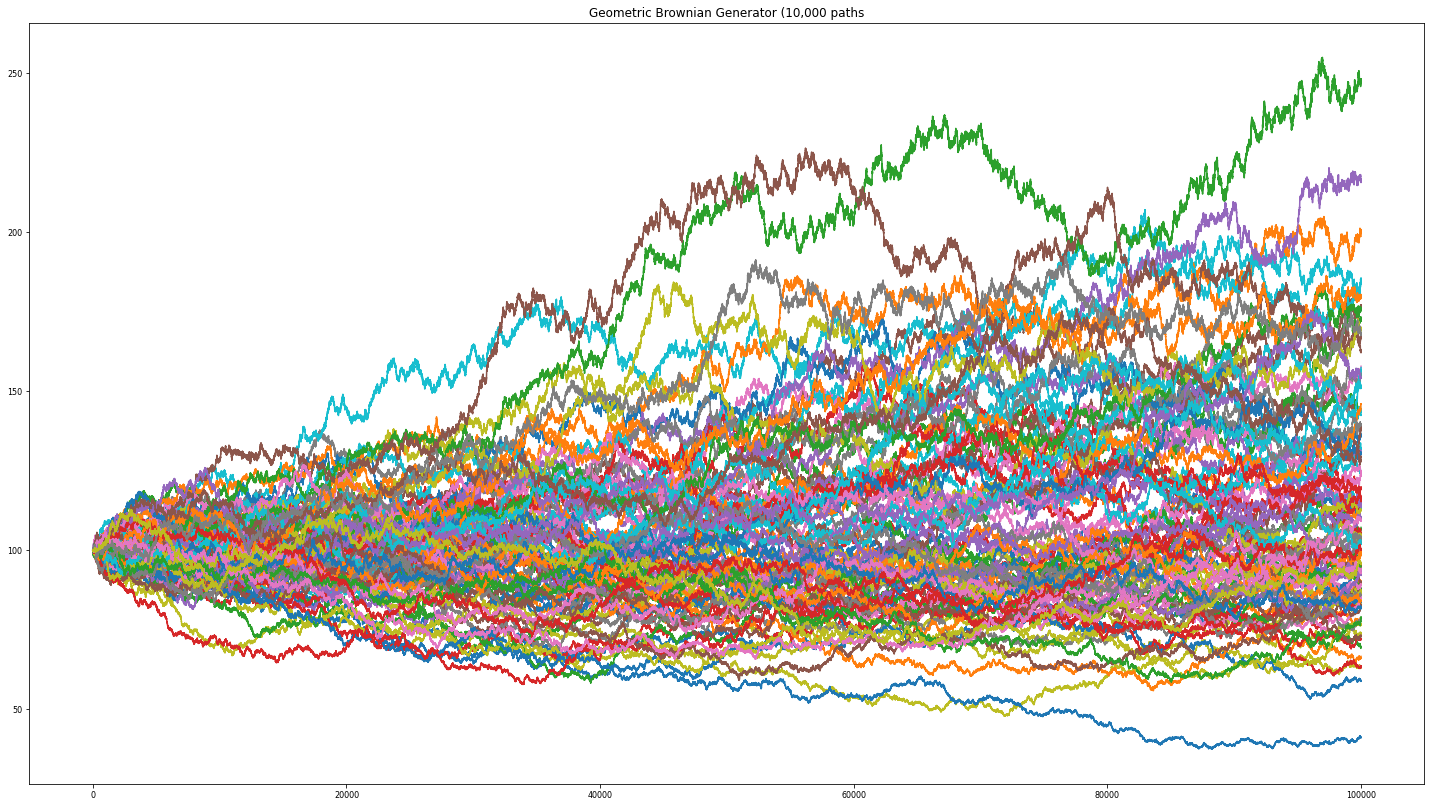

In [0]:
for i in range(1,10000):
  plt.plot(gbm_paths(r,q,N,T,S0,sigma))

plt.title('Geometric Brownian Generator (10,000 paths')
plt.show()

### Black-Scholes Theoretical Price
Call and Put Asian option prices with geometric averaging. The alternative implementation in Tensorlfow offers efficiency and includes the calculations of 1st 2nd and 3rd order Greeks.

#### Conventional Implementation

In [0]:
# Call Options:
def bs_call(r,q,T,K,S0,sigma):
  G0 = S0 * np.exp(0.5 * (r - q) * T - ((sigma**2) * T)/12)
  Sigma_G = sigma/np.sqrt(3)
  d1 = (1/(Sigma_G * np.sqrt(T))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * T)
  d2 = (1/(Sigma_G * np.sqrt(T))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * T)
  c = np.exp(-r * T) * (G0 * norm.cdf(d1) - K * norm.cdf(d2))
  return c

# Put Options:
def bs_put(r,q,T,K,S0,sigma):
  G0 = S0 * np.exp(0.5 * (r - q) * T - ((sigma**2) * T)/12)
  Sigma_G = sigma/np.sqrt(3)
  d1 = (1/(Sigma_G * np.sqrt(T))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * T)
  d2 = (1/(Sigma_G * np.sqrt(T))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * T)
  p = np.exp(-r * T) * (K * norm.cdf(-d2) - G0 * norm.cdf(-d1))
  return p

#### Tensorflow Implementation

In [0]:
# Call Options:
def bs_call_tf(enable_greeks = False):
    S0 = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    q = tf.placeholder(tf.float32)    
    G0 = S0 * tf.exp(0.5 * (r * dt) - ((tf.math.square(sigma)) * dt)/12)
    Sigma_G = sigma/tf.sqrt(3.0)
    Phi = tf.distributions.Normal(0.,1.).cdf
    d_1 = (1/(Sigma_G * tf.sqrt(dt))) * (tf.log(G0/K) + 0.5 * (tf.math.square(Sigma_G)) * dt)
    d_2 = (1/(Sigma_G * tf.sqrt(dt))) * (tf.log(G0/K) - 0.5 * (tf.math.square(Sigma_G)) * dt)
    npv =  tf.exp(-r * dt) * (G0 * Phi(d_1) - K * Phi(d_2))                # GREEKS TABLE:
    target_calc = [npv]                                                    # (e.g. Option Price with respect to Asset Price (S) is delta)
    if enable_greeks:                                                      #                Asset Price (S)   Volatility    Time to Expiry
      greeks = tf.gradients(npv, [S0, sigma, dt])                          # Option Price |     delta            vega           theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt])                    # Delta        |     gamma            vanna          charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt])                # Vega         |     vanna         vomma/volga       veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt])                    # Gamma        |     speed            zomma          color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt])            # Vomma        |      N/A             ultima         totto
         
    def execute_graph(S_zero, strk, maturity, volatility, riskfrate):
        with tf.Session() as sess:
            res = sess.run(target_calc, 
                           {
                               S0: S_zero,
                               K : strk,
                               r : riskfrate,
                               sigma: volatility,
                               dt: maturity})
        return res
    return execute_graph

# Put Options:
def bs_put_tf(enable_greeks = False):
    S0 = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    q = tf.placeholder(tf.float32)    
    G0 = S0 * tf.exp(0.5 * (r * dt) - ((tf.math.square(sigma)) * dt)/12)
    Sigma_G = sigma/tf.sqrt(3.0)
    Phi = tf.distributions.Normal(0.,1.).cdf
    d_1 = (1/(Sigma_G * tf.sqrt(dt))) * (tf.log(G0/K) + 0.5 * (tf.math.square(Sigma_G)) * dt)
    d_2 = (1/(Sigma_G * tf.sqrt(dt))) * (tf.log(G0/K) - 0.5 * (tf.math.square(Sigma_G)) * dt)
    npv =  tf.exp(-r * dt) * (K * Phi(-d_2) - G0 * Phi(-d_1))              # GREEKS TABLE:
    target_calc = [npv]                                                    # (e.g. Option Price with respect to Asset Price (S) is delta)
    if enable_greeks:                                                      #                Asset Price (S)   Volatility    Time to Expiry
      greeks = tf.gradients(npv, [S0, sigma, dt])                          # Option Price |     delta            vega           theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt])                    # Delta        |     gamma            vanna          charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt])                # Vega         |     vanna         vomma/volga       veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt])                    # Gamma        |     speed            zomma          color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt])            # Vomma        |      N/A             ultima         totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
     
    def execute_graph(S_zero, strk, maturity, volatility, riskfrate):
        with tf.Session() as sess:
            res = sess.run(target_calc, 
                           {
                               S0: S_zero,
                               K : strk,
                               r : riskfrate,
                               sigma: volatility,
                               dt: maturity})
        return res
    return execute_graph

### Monte Carlo Simulator with Arithmetic Average
Call and Put Asian option prices with arithmetic averaging. The alternative implementation in Tensorlfow offers efficiency and includes the calculations of 1st 2nd and 3rd order Greeks.

#### Conventional Interpretation

In [0]:
# Call Options:
def mc_call_arithm(it,r,q,T,K,N,S0,sigma):
  mc_call_arithm_payoffs = []
  for i in range(1,it):
    S = gbm_paths(r,q,N,T,S0,sigma)
    S_arithm = np.sum(S)/len(S)
    mc_call_arithm_payoffs.append(np.exp(-r * T) * max(S_arithm - K, 0))
  c = np.mean(mc_call_arithm_payoffs)
  return c

# Put Options:
def mc_put_arithm(it,r,q,T,K,N,S0,sigma):
  mc_put_arithm_payoffs = []
  for i in range(1,it):
    S = gbm_paths(r,q,N,T,S0,sigma)
    S_arithm = np.sum(S)/len(S)
    mc_put_arithm_payoffs.append(np.exp(-r * T) * max(K - S_arithm, 0))
  p = np.mean(mc_put_arithm_payoffs)
  return p

#### Tensorflow Implementation:

In [0]:
# Call Options:
def mc_call_arithm_tf(enable_greeks=False):
    (S0, K, dt, T, sigma, r, dw, S_i) = tf_graph_gbm_paths()
    A = tf.reduce_sum(S_i, axis=1)/(T/dt)
    payout = tf.maximum(A - K, 0)
    npv = tf.exp(-r * T) * tf.reduce_mean(payout)
    target_calc = [npv]
    if enable_greeks:
      greeks = tf.gradients(npv, [S0, sigma, dt]) # delta, vega, theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt]) # gamma, vanna, charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt]) # vanna, vomma/volga, veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt]) # speed, zomma, color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt]) # N/A, ultima, totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
    def pricer(S_zero, strk, maturity, volatility, riskfrate, seed, iterations, timesteps):
      if seed != 0:
        np.random.seed(seed)
      stdnorm_random_variates = np.random.randn(iterations, timesteps)
      with tf.Session() as sess:
        delta_t = maturity / timesteps
        res = sess.run(target_calc,
                       {
                           S0: S_zero,
                           K: strk,
                           r: riskfrate,
                           sigma: volatility,
                           dt: delta_t,
                           T: maturity,
                           dw: stdnorm_random_variates})
        return res
    return pricer


# Put Options:
def mc_put_arithm_tf(enable_greeks=False):
    (S0, K, dt, T, sigma, r, dw, S_i) = tf_graph_gbm_paths()
    A = tf.reduce_sum(S_i, axis=1)/(T/dt)
    payout = tf.maximum(K - A, 0)
    npv = tf.exp(-r * T) * tf.reduce_mean(payout)
    target_calc = [npv]
    if enable_greeks:
      greeks = tf.gradients(npv, [S0, sigma, dt]) # delta, vega, theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt]) # gamma, vanna, charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt]) # vanna, vomma/volga, veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt]) # speed, zomma, color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt]) # N/A, ultima, totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
    def pricer(S_zero, strk, maturity, volatility, riskfrate, seed, iterations, timesteps):
      if seed != 0:
        np.random.seed(seed)
      stdnorm_random_variates = np.random.randn(iterations, timesteps)
      with tf.Session() as sess:
        delta_t = maturity / timesteps
        res = sess.run(target_calc,
                       {
                           S0: S_zero,
                           K: strk,
                           r: riskfrate,
                           sigma: volatility,
                           dt: delta_t,
                           T: maturity,
                           dw: stdnorm_random_variates})
        return res
    return pricer

### Monte Carlo Simulator with Geometric Average

#### Conventional Implementation

In [0]:
# Call Options:
def mc_call_geom(it,r,q,T,K,N,S0,sigma):
  mc_call_geom_payoffs = []
  for i in range(1,it):
    S = gbm_paths(r,q,N,T,S0,sigma)
    S_geom = np.exp(np.mean(np.log(S)))
    mc_call_geom_payoffs.append(np.exp(-r * T) * max(S_geom - K, 0))
  c = np.mean(mc_call_geom_payoffs)
  return c

# Put Options:
def mc_put_geom(it,r,q,T,K,N,S0,sigma):
  mc_put_geom_payoffs = []
  for i in range(1,it):
    S = gbm_paths(r,q,N,T,S0,sigma)
    S_geom = np.exp(np.mean(np.log(S)))
    mc_put_geom_payoffs.append(np.exp(-r * T) * max(K - S_geom, 0))
  p = np.mean(mc_put_geom_payoffs)
  return p

#### Tensorflow Implementation

In [0]:
# Call Options:
def mc_call_geom_tf(enable_greeks=True):
    (S0, K, dt, T, sigma, r, dw, S_i) = tf_graph_gbm_paths()
    A = tf.pow(tf.reduce_prod(S_i, axis=1), dt / T)
    payout = tf.maximum(A - K, 0)
    npv = tf.exp(-r * T) * tf.reduce_mean(payout)                          # GREEKS TABLE:
    target_calc = [npv]                                                    # (e.g. Option Price with respect to Asset Price (S) is delta)
    if enable_greeks:                                                      #                Asset Price (S)   Volatility    Time to Expiry
      greeks = tf.gradients(npv, [S0, sigma, dt])                          # Option Price |     delta            vega           theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt])                    # Delta        |     gamma            vanna          charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt])                # Vega         |     vanna         vomma/volga       veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt])                    # Gamma        |     speed            zomma          color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt])            # Vomma        |      N/A             ultima         totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
    def pricer(S_zero, strk, maturity, volatility, riskfrate, seed, iterations, timesteps):
      if seed != 0:
        np.random.seed(seed)
      stdnorm_random_variates = np.random.randn(iterations, timesteps)
      with tf.Session() as sess:
        delta_t = maturity / timesteps
        res = sess.run(target_calc,
                       {
                           S0: S_zero,
                           K: strk,
                           r: riskfrate,
                           sigma: volatility,
                           dt: delta_t,
                           T: maturity,
                           dw: stdnorm_random_variates})
        return res
    return pricer

# Put Options:
def mc_put_geom_tf(enable_greeks=True):
    (S0, K, dt, T, sigma, r, dw, S_i) = tf_graph_gbm_paths()
    A = tf.pow(tf.reduce_prod(S_i, axis=1), dt / T)
    payout = tf.maximum(K - A, 0)
    npv = tf.exp(-r * T) * tf.reduce_mean(payout)                          # GREEKS TABLE:
    target_calc = [npv]                                                    # (e.g. Option Price with respect to Asset Price (S) is delta)
    if enable_greeks:                                                      #                Asset Price (S)   Volatility    Time to Expiry
      greeks = tf.gradients(npv, [S0, sigma, dt])                          # Option Price |     delta            vega           theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt])                    # Delta        |     gamma            vanna          charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt])                # Vega         |     vanna         vomma/volga       veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt])                    # Gamma        |     speed            zomma          color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt])            # Vomma        |      N/A             ultima         totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
    def pricer(S_zero, strk, maturity, volatility, riskfrate, seed, iterations, timesteps):
      if seed != 0:
        np.random.seed(seed)
      stdnorm_random_variates = np.random.randn(iterations, timesteps)
      with tf.Session() as sess:
        delta_t = maturity / timesteps
        res = sess.run(target_calc,
                       {
                           S0: S_zero,
                           K: strk,
                           r: riskfrate,
                           sigma: volatility,
                           dt: delta_t,
                           T: maturity,
                           dw: stdnorm_random_variates})
        return res
    return pricer

## Performance Tests

### Debugging

In [0]:
seed = np.random.randint(1,500)
geometric = mc_call_geom_tf()
r = 0.02
sigma = 0.1
T = 1
S0 = 2.0
geometric(2.0, 2.0, 1, 0.1, 0.02, 1312, 1000000, 8)
#seed = np.random.randint(1,500)
#arithmetic = mc_call_arithm_tf()
#arithmetic(S0,K,T,sigma,r,1312,it,N)

[0.060575414,
 [0.5722974, 0.47060245, 7.143485],
 [2.937539e-11, 0.23530123, 8.150122],
 [0.23530126, -0.26427463, 8.550039],
 [-3.0928848e-09, -5.376412e-09, 2.2891903],
 [-0.13213739, -0.41572082, -2.7862089]]

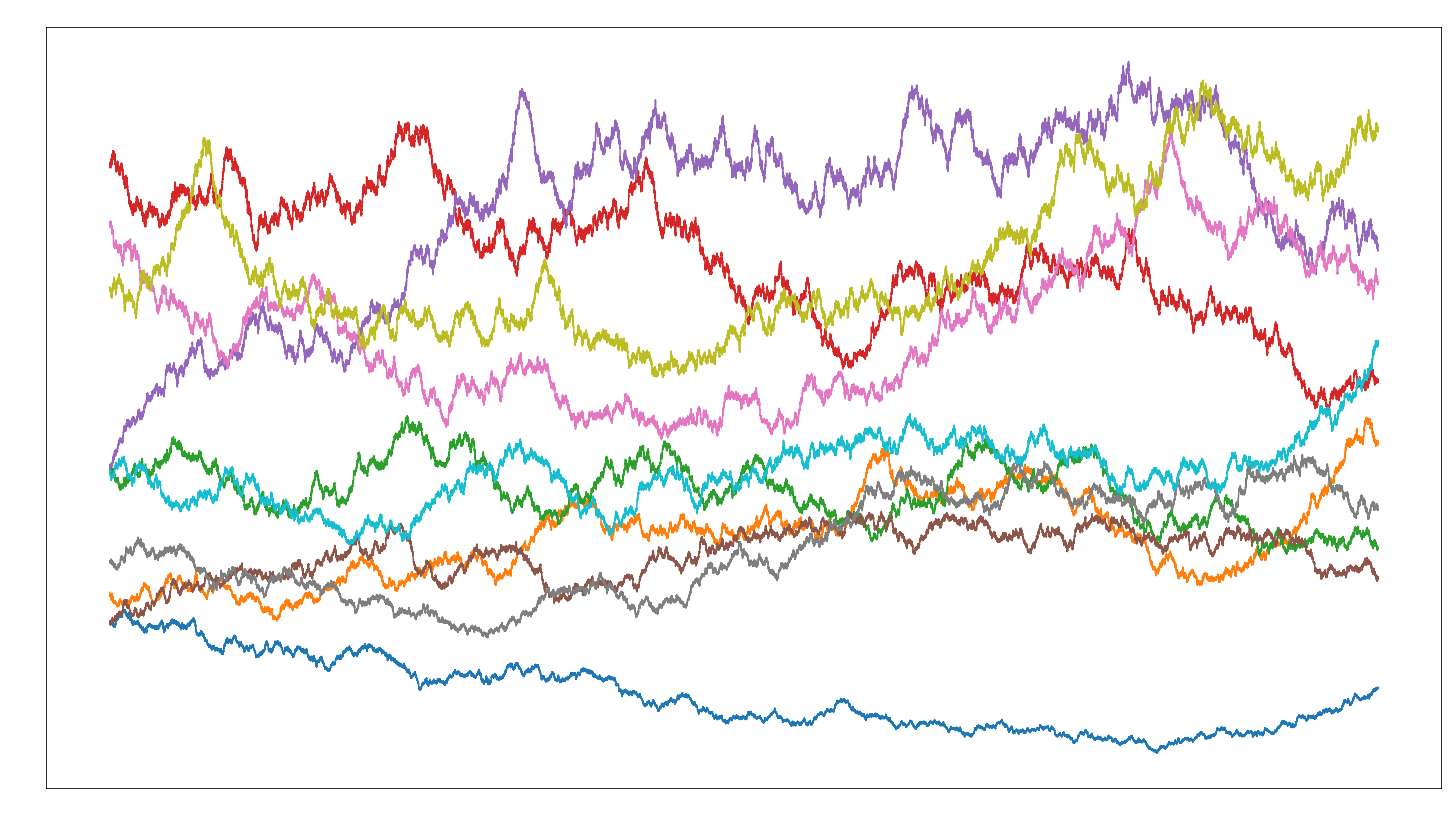

In [0]:
data_generator = tf_gbm_paths()
prices = [100,110,150,250,150,100,230,120,210,150]
daily_data = np.ones((10,N))
S_geometric = np.ones((10,1))
payoffs = np.ones((10,1))
for i in range(0,10):
  seed = np.random.randint(1,5000)
  daily_data[i] = data_generator(prices[i],95,1,0.3,0.15,seed,1,100000)
  S_geometric[i] = np.exp(np.mean(np.log(daily_data[i,:])))
  payoffs[i] = np.exp(-r * T) * max(S_geometric[i] - K, 0)

plt.figure(figsize=(width,height))
_= plt.plot(np.transpose(daily_data))
_ = plt.title('Simulated Stock Prices',fontsize=title_size,color='w')
_ = plt.ylabel('Price',fontsize=ylabel_size,color='w')
_ = plt.xlabel('Time Step',fontsize=xlabel_size,color='w')

#plt.figure(figsize=(width,height))
#_= plt.plot(payoffs)
#_ = plt.title('Payouts',fontsize=title_size,color='w')
#_ = plt.ylabel('Price',fontsize=ylabel_size,color='w')
#_ = plt.xlabel('Time Step',fontsize=xlabel_size,color='w')

#print(payoffs)

In [0]:
Black_Scholes = bs_call_tf()
Results = Black_Scholes(S0,K,T,sigma,r)
#c_greeks_tidy = pd.DataFrame({"Asset Price (S)":c_greeks[:,0], "Volatility":c_greeks[:,1],"Time to Expiry":c_greeks[:,4]},index=['Option Price', 'Delta', 'Vega','Gamma','Vomma'])
#print(c_greeks_tidy)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


### Black-Scholes vs. Monte Carlo: Call Options with Geometric Average

In [0]:
print('- - - - - - - - - - - - - - - - -')

for i in range(95,110,5):
  bs = bs_call(r,q,T,i,S0,sigma)
  mc = mc_call_geom(it,r,q,T,i,N,S0,sigma)
  error = np.abs((bs-mc)/bs)*100
  print('G_c(K=%d,T=%d):'%(i,T))
  print('Black-Scholes:',bs)
  print('Monte Carlo:', mc)
  print('Error: %f%%' % error)
  print('- - - - - - - - - - - - - - - - -')

- - - - - - - - - - - - - - - - -


### Black-Scholes vs. Monte Carlo: Put Options with Geometric Average

In [0]:
print('- - - - - - - - - - - - - - - - -')

for i in range(95,110,5):
  bs = bs_put(r,q,T,i,S0,sigma)
  mc = mc_put_geom(it,r,q,T,i,N,S0,sigma)
  error = np.abs((bs-mc)/bs)*100
  print('G_p(K=%d,T=%d):'%(i,T))
  print('Black-Scholes:',repr(bs))
  print('Monte Carlo:',repr(mc))
  print('Error:',repr(error),'%')
  print('- - - - - - - - - - - - - - - - -')

### Asian call options with arithmetic average: Test Cases (Linetsky 2002):


#### **Test Cases: Parameters**
**%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%**

**C &emsp; r &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; σ &emsp; &emsp; &emsp; &emsp;T &emsp; S0&emsp; &emsp; EE&emsp; &emsp; &emsp; &emsp; &emsp; &emsp; MC &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; %Err**

1 &emsp; 0.0200 &emsp; 0.10 &emsp; 1 &emsp; 2.0 &emsp; 0.05602 &emsp; 0.0559860415 &emsp; 0.017

2 &emsp; 0.1800 &emsp; 0.30 &emsp; 1 &emsp; 2.0 &emsp; 0.21850 &emsp; 0.2183875466 &emsp; 0.059

3 &emsp; 0.0125 &emsp; 0.25 &emsp; 2 &emsp; 2.0 &emsp; 0.17250 &emsp; 0.1722687410 &emsp; 0.063

4 &emsp; 0.0500 &emsp; 0.50 &emsp; 1 &emsp; 1.9 &emsp; 0.19330 &emsp; 0.1931737903 &emsp; 0.084

5 &emsp; 0.0500 &emsp; 0.50 &emsp; 1 &emsp; 2.0 &emsp; 0.24650 &emsp; 0.2464156905 &emsp; 0.095

6 &emsp; 0.0500 &emsp; 0.50 &emsp; 1 &emsp; 2.1 &emsp; 0.30640 &emsp; 0.3062203648 &emsp; 0.106

7 &emsp; 0.0500 &emsp; 0.50 &emsp; 2 &emsp; 2.0 &emsp; 0.35030 &emsp; 0.3500952190 &emsp; 0.146

**%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%**

**Notes:**
* *(EE = Eigenfunction Expansion i.e. the Black-Scholes analytic result in 
this algorithm; MC = Monte-Carlo estimate);*
* *All test cases have a strike K = 2.0 and a dividend yield q = 0.0;*

#### Set K = 2.0, q = 0.0:

In [0]:
# In all test cases, K = 2.0 and q = 0.0:
K = 2.0
q = 0.0

#### Test Cases:

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 1:
r = 0.02
sigma = 0.1
T = 1
S0 = 2.0

lntk1 = 0.0559860415
mc = mc_call_arithm(it,0.02,q,1,2.0,N,2.0,0.1)
error = np.abs((lntk1-mc)/lntk1)*100
print('Case 1 (r=0.02, sigma=0.10, T=1, S0=2.0):')
print('G_c(K=%d,T=%d):'%(2.0,1))
print('Linetsky:',repr(lntk1))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 2:
r = 0.18
sigma = 0.30
T = 1.0
S0 = 2.0

lntk2 = 0.2183875466
mc = mc_call_arithm(it,r,q,T,K,N,S0,sigma)
error = np.abs((lntk2-mc)/lntk2)*100
print('Case 2 (r = 0.18, sigma = 0.30, T = 1, S0 = 2.0):')
print('G_c(K=%d,T=%d):'%(2.0,1))
print('Linetsky:',repr(lntk2))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 3:
r = 0.0125
sigma = 0.25
T = 2.0
S0 = 2.0

lntk3 = 0.1722687410
mc = mc_call_arithm(it,r,q,T,K,N,S0,sigma)
error = np.abs((lntk3-mc)/lntk3)*100
print('Case 3 (r = 0.0125, sigma = 0.25, T = 2, S0 = 2.0):')
print('G_c(K=%d,T=%d):'%(2.0,2))
print('Linetsky:',repr(lntk3))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 4:
r = 0.05
sigma = 0.50
T = 1.0
S0 = 1.9

lntk4 = 0.1931737903
mc = mc_call_arithm(it,r,q,T,K,N,S0,sigma)
error = np.abs((lntk4-mc)/lntk4)*100
print('Case 4 (r = 0.05, sigma = 0.50, T = 1, S0 = 1.9):')
print('G_c(K=%d,T=%d):'%(2.0,1))
print('Linetsky:',repr(lntk4))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 5:
r = 0.05
sigma = 0.50
T = 1.0
S0 = 2.0

lntk5 = 0.2464156905
mc = mc_call_arithm(it,r,q,T,K,N,S0,sigma)
error = np.abs((lntk5-mc)/lntk5)*100
print('Case 5 (r = 0.05, sigma = 0.50, T = 1, S0 = 2.0):')
print('G_c(K=%d,T=%d):'%(2.0,1))
print('Linetsky:',repr(lntk5))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 6:
r = 0.05
sigma = 0.50
T = 1.0
S0 = 2.1

lntk6 = 0.3062203648
mc = mc_call_arithm(it,r,q,T,K,N,S0,sigma)
error = np.abs((lntk6-mc)/lntk6)*100
print('Case 6 (r = 0.05, sigma = 0.50, T = 1, S0 = 2.1):')
print('G_c(K=%d,T=%d):'%(2.0,1))
print('Linetsky:',repr(lntk6))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 7:
r = 0.05
sigma = 0.50
T = 2.0
S0 = 2.0

lntk7 = 0.3500952190
mc = mc_call_arithm(it,r,q,T,K,N,S0,sigma)
error = np.abs((lntk7-mc)/lntk7)*100
print('Case 7 (r = 0.05, sigma = 0.50, T = 2.0, S0 = 2.0):')
print('G_c(K=%d,T=%d):'%(2.0,2))
print('Linetsky:',repr(lntk7))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

## Error Estimation

### Monte Carlo Geometric Pricer:

**Sensitivity of Monte Carlo pricer to number of simulations:**

The results of 1000,5000,10000,50000,100000,500000,1000000, and 5000000 iterations are compared to the Black-Scholes theoretical price. The errors are then plotted against the number of iterations in order to determine the sensitivity of the pricing algorithm to the number of iterations.

**The following constants are used in all experiments:**
* S0 = 100
* r = 0.15
* q = 0.0
* T = 1.0
* sigma = 0.3
* K = 95

In [0]:
it_cases = [1000,5000,10000,50000,100000,500000,1000000]
bs_call = bs_call_tf()
bs_c = bs_call(100,95,1,0.3,0.15)
bs_c = bs_c[0]
print('The Black-Scholes Theoretical Price is:',bs_c)
errors = []
mc_call = mc_call_geom_tf()
# Call Options:
for i in range(0,len(it_cases)):
  seed = np.random.randint(1,500)
  mc_c = mc_call(100,95,1,0.3, 0.15, 1312, it_cases[i], 8)
  mc_c = mc_c[0]
  print('For %d iterations, the Monte Carlo estimate is:' %it_cases[i],mc_c)
  error = 100 * (np.abs(mc_c-bs_c)/bs_c)
  errors.append(error)

print(errors)

## Hedging Tests

### Daily Data Generation